<a href="https://colab.research.google.com/github/souayboss/Deep_learning/blob/main/Initialization_techn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time 
import pickle as pk
from google.colab import drive
import tensorflow as tf
from keras.datasets import cifar10
from tensorflow.keras.layers import Dense , Conv2D, concatenate, MaxPooling2D, UpSampling2D, Input 
from tensorflow.keras.layers import Softmax, Dropout, Flatten,  ReLU, concatenate, BatchNormalization
from tensorflow.keras import Model as Model_ , Sequential
# drive.mount('/content/gdrive', force_remount=True)i

In [ ]:
# WRAP THESE ON A FUNCTION or CLASS CALL!
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train/255.
x_test  = x_test / 255.

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.layers import BatchNormalization
class KGene_conv_b(Model_):
  def __init__(self, outchannel, kernel=3, stride=1, padding='valid', pool=False, Batchnorm=False, prebatch=True, init_ref="he_uniform"):
    super(KGene_conv_b, self).__init__() 
    layer_block = [Conv2D(outchannel, kernel_size=kernel, strides=stride, padding=padding, kernel_initializer=init_ref),ReLU()]
    if pool:
      layer_block.append(MaxPooling2D((3,3),strides=2))
    if Batchnorm:
      layer_block.append(BatchNormalization())
    if prebatch:
      layer_block = [Conv2D(outchannel, kernel_size=kernel, strides=stride, padding=padding, kernel_initializer=init_ref), BatchNormalization( ),
                     ReLU()]
      if pool:
        layer_block.append(MaxPooling2D((3,3),strides=2))

    self.conv = Sequential(layer_block)
  def call(self, x):
    conv = self.conv(x)
    return conv
  
    
class KGene_fully_block(Model_):
  def __init__(self, outsize, dropout, init_ref):
    super(KGene_fully_block, self).__init__()
    self.fc = Sequential([                        
      Dense(outsize, kernel_initializer=init_ref),
      ReLU(),
      Dropout(dropout),
    ])
  def call(self, x):
    return self.fc(x)

class Generic32Batch(Model_):
  def __init__(self, dropout=0.5, batchnorm=True, init_ref="he_uniform"):
    super(Generic32Batch, self).__init__()
    self.conv1 = KGene_conv_b(32, padding='same', Batchnorm=batchnorm, init_ref=init_ref)
    self.conv2 = KGene_conv_b(64,kernel=3, padding='same',pool=True, Batchnorm=batchnorm, init_ref=init_ref)
    self.conv3 = KGene_conv_b(128,kernel=3, padding='same',init_ref=init_ref) 
    self.conv4 = KGene_conv_b(128,kernel=3, padding='same',init_ref=init_ref)
    self.conv5 = KGene_conv_b(256,kernel=3, padding='same',init_ref=init_ref,pool=True)
    self.flatt  = Flatten()
    self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(2,2))
    self.fc1   = KGene_fully_block(1024,dropout, init_ref=init_ref)
    self.fc2   = KGene_fully_block(1024,dropout, init_ref=init_ref)
    self.out   = Dense(10)
    self.softmax = Softmax()

  def call(self, input_x):
    x = self.conv1(input_x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avg_pool(x)
    x = self.flatt(x)  
    x = self.fc1(x)
    x = self.fc2(x)
    
    out = self.out(x)
    out = self.softmax(out)
    return out
    


# model = Sequential()
# model.add(Conv2D(filters = 32, kernel_size = (3, 3),
#           input_shape = (32, 32, 3),
#           activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Conv2D(32, 3, 3, activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Flatten())
# model.add(Dense(units = 128, activation = 'relu'))
# model.add(Dense(units = 10, activation = 'softmax'))

In [ ]:
model = Generic32Batch()
Optim = Optimizer(model, mb=32)


In [ ]:
%time trl, tsl, tra,tsa = Optim.run(x_train, y_train, x_test, y_test, epochs=10)

epoch:  1,  TRAIN LOSS:  1.735732157681893, TEST LOSS:  1.2893610223413656,  TRAIN ACC:  38.42, TEST ACC:  54.949999999999996
epoch:  2,  TRAIN LOSS:  1.0475260678080511, TEST LOSS:  0.9542749342255699,  TRAIN ACC:  63.754, TEST ACC:  66.25999999999999
epoch:  3,  TRAIN LOSS:  0.7974077291400556, TEST LOSS:  0.8967943204858433,  TRAIN ACC:  72.744, TEST ACC:  69.66
epoch:  4,  TRAIN LOSS:  0.6654484946702584, TEST LOSS:  0.753165546126259,  TRAIN ACC:  77.78399999999999, TEST ACC:  74.71
epoch:  5,  TRAIN LOSS:  0.5535016564779837, TEST LOSS:  0.7031292591612941,  TRAIN ACC:  81.434, TEST ACC:  77.03
epoch:  6,  TRAIN LOSS:  0.4727440824468816, TEST LOSS:  0.5687971408374775,  TRAIN ACC:  84.176, TEST ACC:  80.65
epoch:  7,  TRAIN LOSS:  0.4124256858193409, TEST LOSS:  0.6092192958623838,  TRAIN ACC:  86.198, TEST ACC:  80.39
epoch:  8,  TRAIN LOSS:  0.35761653313261915, TEST LOSS:  0.614938711348814,  TRAIN ACC:  88.068, TEST ACC:  79.84
epoch:  9,  TRAIN LOSS:  0.31718587838661494, T

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%time model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.2883 - accuracy: 0.3012 - val_loss: 1.2035 - val_accuracy: 0.5793
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0700 - accuracy: 0.6264 - val_loss: 0.8947 - val_accuracy: 0.6930
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8075 - accuracy: 0.7231 - val_loss: 0.7114 - val_accuracy: 0.7589
Epoch 4/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.6647 - accuracy: 0.7750 - val_loss: 0.6665 - val_accuracy: 0.7712
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.5565 - accuracy: 0.8152 - val_loss: 0.6908 - val_accuracy: 0.7673
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.4794 - accuracy: 0.8411 - val_loss: 0.5413 - val_accuracy: 0.8183
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.4151 - accuracy: 0.8607 - val_loss: 0.7839 - val_ac

In [ ]:
 
import tensorflow as tf
import os
tf.keras.backend.set_floatx('float64')

class Optimizer:
  def __init__(self, model, mb = 8, lr = 0.001, loss = tf.keras.losses.SparseCategoricalCrossentropy, opt=tf.keras.optimizers.Adam):
     
    self.model     = model
    self.loss      = loss()
    self.optimizer = opt(learning_rate = lr)  # initialize the optimizer with the given lerning rate
    self.mb        = mb
    self.train_loss     = tf.keras.metrics.Mean(name='train_loss')  # hold the training loss

    self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

    self.test_loss     = tf.keras.metrics.Mean(name='test_loss')
    self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

  @tf.function
  def train_step(self, x , y):
    with tf.GradientTape() as tape:           # Record operations for automatic differentiation ()
      predictions = self.model(x,training=True)
      loss = self.loss(y, predictions)        # calculting the loss
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables)) # backpropagating
    self.train_loss(loss)                     # recording the training loss
    self.train_accuracy(y, predictions)
    return loss

  @tf.function
  def test_step(self, x , y):
    predictions = self.model(x, training=False)
    loss = self.loss(y, predictions)
    self.test_loss(loss)                      #recording the test loss
    self.test_accuracy(y, predictions)

  def train (self):
    for mbX, mbY in self.train_ds:
      self.train_step(mbX, mbY)


  def test  (self):
    for mbX, mbY in self.test_ds:
      self.test_step(mbX, mbY)
  def run(self, dataX, dataY, testX, testY, epochs, verbose=2 ):
    historyTR = []
    historyTS = []
    historyTRAC = []
    historyTSAC = []
     
    template = '{} {}, {} {},{} {}, {} {},{} {}'
    # shuffle the training data with a buffer size of 16000
    self.train_ds = tf.data.Dataset.from_tensor_slices((dataX, dataY)).shuffle(1000).batch(self.mb)
    self.test_ds  = tf.data.Dataset.from_tensor_slices((testX,testY)).batch(self.mb)
    for epoch in range(epochs):

        self.train ()
        self.test()
        
        if verbose > 0:
            print(template.format("epoch: ", epoch+1,
                          " TRAIN LOSS: ", self.train_loss.result(),
                          " TEST LOSS: " , self.test_loss.result(),
                          " TRAIN ACC: " , self.train_accuracy.result()*100,
                          " TEST ACC: "  , self.test_accuracy.result()*100)
            )
        temp = '{}'
        historyTR.append(float(temp.format(self.train_loss.result())))
        historyTS.append(float(temp.format(self.test_loss.result() )))
        historyTRAC.append(float(temp.format(self.train_accuracy.result())))
        historyTSAC.append(float(temp.format(self.test_accuracy.result())))

        self.train_loss.reset_states()
        self.train_accuracy.reset_states()
        self.test_loss.reset_states()
        self.test_accuracy.reset_states()
    print('Training: complete!')
    return historyTR,historyTS, historyTRAC,historyTSAC

# Using He/ kaiming initializer 

In [ ]:
from tensorflow.keras.layers import BatchNormalization
class KGene_conv_b(Model_):
  def __init__(self, outchannel, kernel=3, stride=1, padding='valid', pool=False, Batchnorm=False, prebatch=True, init_ref="he_uniform"):
    super(KGene_conv_b, self).__init__() 
    layer_block = [Conv2D(outchannel, kernel_size=kernel, strides=stride, padding=padding, kernel_initializer=init_ref),ReLU()]
    if pool:
      layer_block.append(MaxPooling2D((3,3),strides=2))
    if Batchnorm:
      layer_block.append(BatchNormalization())
    if prebatch:
      layer_block = [Conv2D(outchannel, kernel_size=kernel, strides=stride, padding=padding, kernel_initializer=init_ref), BatchNormalization( ),
                     ReLU()]
      if pool:
        layer_block.append(MaxPooling2D((3,3),strides=2))

    self.conv = Sequential(layer_block)
  def call(self, x):
    conv = self.conv(x)
    return conv
  
    
class KGene_fully_block(Model_):
  def __init__(self, outsize, dropout, init_ref):
    super(KGene_fully_block, self).__init__()
    self.fc = Sequential([                        
      Dense(outsize, kernel_initializer=init_ref),
      ReLU(),
      Dropout(dropout),
    ])
  def call(self, x):
    return self.fc(x)

class Generic32Batch(Model_):
  def __init__(self, dropout=0.5, batchnorm=True, init_ref="he_uniform"):
    super(Generic32Batch, self).__init__()
    self.conv1 = KGene_conv_b(32, padding='same', Batchnorm=batchnorm, init_ref=init_ref)
    self.conv2 = KGene_conv_b(64,kernel=3, padding='same',pool=True, Batchnorm=batchnorm, init_ref=init_ref)
    self.conv3 = KGene_conv_b(128,kernel=3, padding='same',init_ref=init_ref) 
    self.conv4 = KGene_conv_b(128,kernel=3, padding='same',init_ref=init_ref)
    self.conv5 = KGene_conv_b(256,kernel=3, padding='same',init_ref=init_ref,pool=True)
    self.flatt  = Flatten()
    self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(2,2))
    self.fc1   = KGene_fully_block(1024,dropout, init_ref=init_ref)
    self.fc2   = KGene_fully_block(1024,dropout, init_ref=init_ref)
    self.out   = Dense(10)
    self.softmax = Softmax()

  def call(self, input_x):
    x = self.conv1(input_x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avg_pool(x)
    x = self.flatt(x)  
    x = self.fc1(x)
    x = self.fc2(x)
    
    out = self.out(x)
    out = self.softmax(out)
    return out
    

In [ ]:
gmodel32batch = Generic32Batch()

In [ ]:
gmodel32batch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = gmodel32batch.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
1563/1563 [==============================] - 16s 11ms/step - loss: 1.7112 - accuracy: 0.3938 - val_loss: 1.2346 - val_accuracy: 0.5626
Epoch 2/25
1563/1563 [==============================] - 16s 11ms/step - loss: 1.0683 - accuracy: 0.6250 - val_loss: 0.9229 - val_accuracy: 0.6834
Epoch 3/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8059 - accuracy: 0.7235 - val_loss: 0.9210 - val_accuracy: 0.7001
Epoch 4/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6640 - accuracy: 0.7780 - val_loss: 0.8114 - val_accuracy: 0.7328
Epoch 5/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5557 - accuracy: 0.8127 - val_loss: 0.6037 - val_accuracy: 0.8044
Epoch 6/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4822 - accuracy: 0.8398 - val_loss: 0.5772 - val_accuracy: 0.8029
Epoch 7/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4157 - accuracy: 0.8607 - val_loss: 0.5617 -

In [ ]:
gmodel32batch_rand = Generic32Batch(init_ref='random_normal')

In [ ]:
gmodel32batch_rand.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_norm = gmodel32batch_rand.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
1563/1563 [==============================] - 16s 10ms/step - loss: 1.8521 - accuracy: 0.3578 - val_loss: 1.4198 - val_accuracy: 0.4747
Epoch 2/25
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1277 - accuracy: 0.6050 - val_loss: 1.0077 - val_accuracy: 0.6436
Epoch 3/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8479 - accuracy: 0.7114 - val_loss: 0.7999 - val_accuracy: 0.7271
Epoch 4/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6977 - accuracy: 0.7637 - val_loss: 0.6945 - val_accuracy: 0.7632
Epoch 5/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5868 - accuracy: 0.8036 - val_loss: 0.6541 - val_accuracy: 0.7715
Epoch 6/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5125 - accuracy: 0.8281 - val_loss: 0.5810 - val_accuracy: 0.8045
Epoch 7/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4469 - accuracy: 0.8493 - val_loss: 0.5826 -

# FIXING the FC Layer before the last and Kaiming/He initializer 

In [ ]:
from tensorflow.keras.layers import BatchNormalization
class KGene_conv_b(Model_):
  def __init__(self, outchannel, kernel=3, stride=1, padding='valid', pool=False, Batchnorm=False, prebatch=True, init_ref="he_uniform"):
    super(KGene_conv_b, self).__init__() 
    layer_block = [Conv2D(outchannel, kernel_size=kernel, strides=stride, padding=padding, kernel_initializer=init_ref),ReLU()]
    if pool:
      layer_block.append(MaxPooling2D((3,3),strides=2))
    if Batchnorm:
      layer_block.append(BatchNormalization())
    if prebatch:
      layer_block = [Conv2D(outchannel, kernel_size=kernel, strides=stride, padding=padding, kernel_initializer=init_ref), BatchNormalization( ),
                     ReLU()]
      if pool:
        layer_block.append(MaxPooling2D((3,3),strides=2))

    self.conv = Sequential(layer_block)
  def call(self, x):
    conv = self.conv(x)
    return conv
  
    
class KGene_fully_block(Model_):
  def __init__(self, outsize, dropout, init_ref, trainable=True):
    super(KGene_fully_block, self).__init__()
    self.fc = Sequential([                        
      Dense(outsize, kernel_initializer=init_ref, trainable=trainable),
      ReLU(),
      Dropout(dropout),
    ])
  def call(self, x):
    return self.fc(x)

class Generic32Batch_he(Model_):
  def __init__(self, dropout=0.5, batchnorm=True, init_ref="he_uniform"):
    super(Generic32Batch_he, self).__init__()
    self.conv1 = KGene_conv_b(32, padding='same', Batchnorm=batchnorm, init_ref=init_ref)
    self.conv2 = KGene_conv_b(64,kernel=3, padding='same',pool=True, Batchnorm=batchnorm, init_ref=init_ref)
    self.conv3 = KGene_conv_b(128,kernel=3, padding='same',init_ref=init_ref) 
    self.conv4 = KGene_conv_b(128,kernel=3, padding='same',init_ref=init_ref)
    self.conv5 = KGene_conv_b(256,kernel=3, padding='same',init_ref=init_ref,pool=True)
    self.flatt  = Flatten()
    self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(2,2))
    self.fc1   = KGene_fully_block(1024,dropout, init_ref=init_ref)
    self.fc2   = KGene_fully_block(1024,dropout, init_ref=init_ref, trainable=False)
    self.out   = Dense(10)
    self.softmax = Softmax()

  def call(self, input_x):
    x = self.conv1(input_x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avg_pool(x)
    x = self.flatt(x)  
    x = self.fc1(x)
    x = self.fc2(x)
    
    out = self.out(x)
    out = self.softmax(out)
    return out
    

In [ ]:
gmodel32fix = Generic32Batch_he()

In [ ]:
gmodel32fix.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_genbefor = gmodel32fix.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6796 - accuracy: 0.4145 - val_loss: 1.3789 - val_accuracy: 0.5211
Epoch 2/25
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0146 - accuracy: 0.6518 - val_loss: 0.8986 - val_accuracy: 0.6935
Epoch 3/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.7969 - accuracy: 0.7321 - val_loss: 1.0503 - val_accuracy: 0.6461
Epoch 4/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6642 - accuracy: 0.7785 - val_loss: 0.8489 - val_accuracy: 0.7188
Epoch 5/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5630 - accuracy: 0.8147 - val_loss: 0.6487 - val_accuracy: 0.7827
Epoch 6/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4969 - accuracy: 0.8371 - val_loss: 0.6073 - val_accuracy: 0.7977
Epoch 7/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4290 - accuracy: 0.8586 - val_loss: 0.6403 -

# Fix last layer and Kaiming/he intializer 

In [ ]:
from tensorflow.keras.layers import BatchNormalization
class KGene_conv_b(Model_):
  def __init__(self, outchannel, kernel=3, stride=1, padding='valid', pool=False, Batchnorm=False, prebatch=True, init_ref="he_uniform"):
    super(KGene_conv_b, self).__init__() 
    layer_block = [Conv2D(outchannel, kernel_size=kernel, strides=stride, padding=padding, kernel_initializer=init_ref),ReLU()]
    if pool:
      layer_block.append(MaxPooling2D((3,3),strides=2))
    if Batchnorm:
      layer_block.append(BatchNormalization())
    if prebatch:
      layer_block = [Conv2D(outchannel, kernel_size=kernel, strides=stride, padding=padding, kernel_initializer=init_ref), BatchNormalization( ),
                     ReLU()]
      if pool:
        layer_block.append(MaxPooling2D((3,3),strides=2))

    self.conv = Sequential(layer_block)
  def call(self, x):
    conv = self.conv(x)
    return conv
  
    
class KGene_fully_block(Model_):
  def __init__(self, outsize, dropout, init_ref, trainable=True):
    super(KGene_fully_block, self).__init__()
    self.fc = Sequential([                        
      Dense(outsize, kernel_initializer=init_ref, trainable=trainable),
      ReLU(),
      Dropout(dropout),
    ])
  def call(self, x):
    return self.fc(x)

class Generic32Batch_hel(Model_):
  def __init__(self, dropout=0.5, batchnorm=True, init_ref="he_uniform"):
    super(Generic32Batch_hel, self).__init__()
    self.conv1 = KGene_conv_b(32, padding='same', Batchnorm=batchnorm, init_ref=init_ref)
    self.conv2 = KGene_conv_b(64,kernel=3, padding='same',pool=True, Batchnorm=batchnorm, init_ref=init_ref)
    self.conv3 = KGene_conv_b(128,kernel=3, padding='same',init_ref=init_ref) 
    self.conv4 = KGene_conv_b(128,kernel=3, padding='same',init_ref=init_ref)
    self.conv5 = KGene_conv_b(256,kernel=3, padding='same',init_ref=init_ref,pool=True)
    self.flatt  = Flatten()
    self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(2,2))
    self.fc1   = KGene_fully_block(1024,dropout, init_ref=init_ref)
    self.fc2   = KGene_fully_block(1024,dropout, init_ref=init_ref)
    self.out   = Dense(10, trainable=False)
    self.softmax = Softmax()

  def call(self, input_x):
    x = self.conv1(input_x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avg_pool(x)
    x = self.flatt(x)  
    x = self.fc1(x)
    x = self.fc2(x)
    
    out = self.out(x)
    out = self.softmax(out)
    return out
    

In [ ]:
gmodel32fix_last = Generic32Batch_hel()

In [ ]:
gmodel32fix_last.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_last = gmodel32fix_last.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
1563/1563 [==============================] - 16s 11ms/step - loss: 1.7051 - accuracy: 0.4056 - val_loss: 1.2159 - val_accuracy: 0.5783
Epoch 2/25
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0024 - accuracy: 0.6542 - val_loss: 0.8411 - val_accuracy: 0.6967
Epoch 3/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.7689 - accuracy: 0.7399 - val_loss: 0.6943 - val_accuracy: 0.7741
Epoch 4/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6346 - accuracy: 0.7863 - val_loss: 0.6529 - val_accuracy: 0.7780
Epoch 5/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5439 - accuracy: 0.8181 - val_loss: 0.5819 - val_accuracy: 0.8052
Epoch 6/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4624 - accuracy: 0.8451 - val_loss: 0.5701 - val_accuracy: 0.8094
Epoch 7/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.3936 - accuracy: 0.8681 - val_loss: 0.6001 -

# Using normal distribution in the last layer and fix 

In [ ]:
from tensorflow.keras.layers import BatchNormalization
class KGene_conv_b(Model_):
  def __init__(self, outchannel, kernel=3, stride=1, padding='valid', pool=False, Batchnorm=False, prebatch=True, init_ref="he_uniform"):
    super(KGene_conv_b, self).__init__() 
    layer_block = [Conv2D(outchannel, kernel_size=kernel, strides=stride, padding=padding, kernel_initializer=init_ref),ReLU()]
    if pool:
      layer_block.append(MaxPooling2D((3,3),strides=2))
    if Batchnorm:
      layer_block.append(BatchNormalization())
    if prebatch:
      layer_block = [Conv2D(outchannel, kernel_size=kernel, strides=stride, padding=padding, kernel_initializer=init_ref), BatchNormalization( ),
                     ReLU()]
      if pool:
        layer_block.append(MaxPooling2D((3,3),strides=2))

    self.conv = Sequential(layer_block)
  def call(self, x):
    conv = self.conv(x)
    return conv
  
    
class KGene_fully_block(Model_):
  def __init__(self, outsize, dropout, init_ref, trainable=True):
    super(KGene_fully_block, self).__init__()
    self.fc = Sequential([                        
      Dense(outsize, kernel_initializer=init_ref, trainable=trainable),
      ReLU(),
      Dropout(dropout),
    ])
  def call(self, x):
    return self.fc(x)

class Generic32Batch_hel_Nor(Model_):
  def __init__(self, dropout=0.5, batchnorm=True, init_ref="he_uniform"):
    super(Generic32Batch_hel_Nor, self).__init__()
    self.conv1 = KGene_conv_b(32, padding='same', Batchnorm=batchnorm, init_ref=init_ref)
    self.conv2 = KGene_conv_b(64,kernel=3, padding='same',pool=True, Batchnorm=batchnorm, init_ref=init_ref)
    self.conv3 = KGene_conv_b(128,kernel=3, padding='same',init_ref=init_ref) 
    self.conv4 = KGene_conv_b(128,kernel=3, padding='same',init_ref=init_ref)
    self.conv5 = KGene_conv_b(256,kernel=3, padding='same',init_ref=init_ref,pool=True)
    self.flatt  = Flatten()
    self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(2,2))
    self.fc1   = KGene_fully_block(1024,dropout, init_ref=init_ref)
    self.fc2   = KGene_fully_block(1024,dropout, init_ref=init_ref)
    self.out   = Dense(10, trainable=False, kernel_initializer='random_normal')
    self.softmax = Softmax()

  def call(self, input_x):
    x = self.conv1(input_x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avg_pool(x)
    x = self.flatt(x)  
    x = self.fc1(x)
    x = self.fc2(x)
    
    out = self.out(x)
    out = self.softmax(out)
    return out
    

In [ ]:
gmodel32fix_lastn = Generic32Batch_hel_Nor()

In [ ]:
gmodel32fix_lastn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_lastn = gmodel32fix_lastn.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
1563/1563 [==============================] - 16s 10ms/step - loss: 1.8495 - accuracy: 0.3453 - val_loss: 1.2358 - val_accuracy: 0.5549
Epoch 2/25
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1230 - accuracy: 0.6076 - val_loss: 1.2934 - val_accuracy: 0.5662
Epoch 3/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8281 - accuracy: 0.7203 - val_loss: 0.8158 - val_accuracy: 0.7241
Epoch 4/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6668 - accuracy: 0.7743 - val_loss: 0.6496 - val_accuracy: 0.7820
Epoch 5/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5595 - accuracy: 0.8127 - val_loss: 0.6316 - val_accuracy: 0.7904
Epoch 6/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4733 - accuracy: 0.8423 - val_loss: 0.5558 - val_accuracy: 0.8142
Epoch 7/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4106 - accuracy: 0.8632 - val_loss: 0.5992 -

In [ ]:
optim = tf.keras.optimizers.Adam(lr=0.0002)
gmodel32fixlastn = Generic32Batch_hel_Nor()
gmodel32fixlastn.compile(optimizer= optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist_lastn1 = gmodel32fixlastn.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7573 - accuracy: 0.3811 - val_loss: 1.2757 - val_accuracy: 0.5401
Epoch 2/25
1563/1563 [==============================] - 16s 10ms/step - loss: 1.2418 - accuracy: 0.5602 - val_loss: 0.9663 - val_accuracy: 0.6662
Epoch 3/25
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0048 - accuracy: 0.6522 - val_loss: 0.8093 - val_accuracy: 0.7215
Epoch 4/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8535 - accuracy: 0.7061 - val_loss: 0.7667 - val_accuracy: 0.7356
Epoch 5/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.7318 - accuracy: 0.7502 - val_loss: 0.6773 - val_accuracy: 0.7675
Epoch 6/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6447 - accuracy: 0.7809 - val_loss: 0.6091 - val_accuracy: 0.7940
Epoch 7/25
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5625 - accuracy: 0.8093 - val_loss: 0.5789 -

# plotting the result 

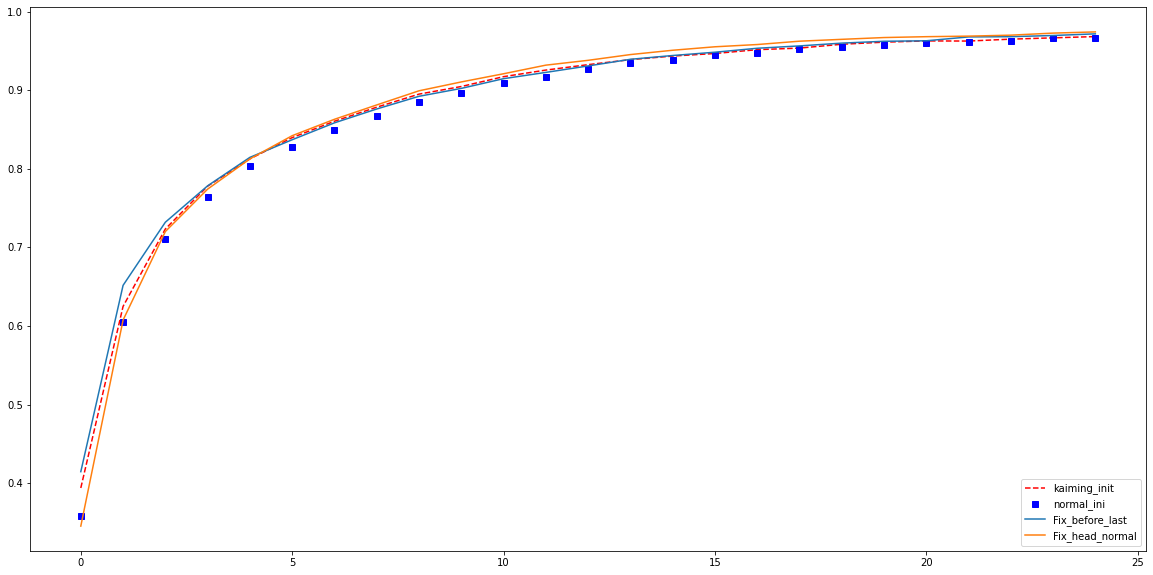

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline 

# plt.plot(hist["accuracy"], 'r--', t, t**2, 'bs', t, t**3, 'g^')
fig = plt.figure(figsize=(20,10))
plt.plot(hist.history["accuracy"], 'r--', label='kaiming_init')
plt.plot(hist_norm.history["accuracy"], 'bs', label='normal_ini')
plt.plot(hist_genbefor.history["accuracy"], '', label='Fix_before_last')
plt.plot(hist_lastn.history["accuracy"], '', label='Fix_head_normal')
plt.legend('lower right',)
plt.show()
 